In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import argparse
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import pandas as pd

# Load Datasets

In the following cell the mean and the std of the CIFAR10 and MNIST data are calculated in order to use these values as parameters when normalising the datasets. Note that the MNIST data set will have 1 value for the mean and one value for the std since the images only have one channel, while there will be 3 values of the mean and 3 values of the std for the CIFAR10 dataset, one per channel.

In [3]:
#dataset_names = ('cifar10','mnist')

#for name in dataset_names:
  #if name == "cifar10":
   # train_transform = transforms.Compose([transforms.ToTensor()])
    #train_set = datasets.CIFAR10(root='cifar_dataset', train=True, download=True, transform=train_transform)

    #print('Information for the CIFAR10 dataset:')
    #print('Shape:', train_set.data.shape)
    #print('Mean:', train_set.data.mean(axis=(0,1,2))/255)
    #print('Standard deviation:', train_set.data.std(axis=(0,1,2))/255)
    #print('-' *10)

  #elif name == "mnist":
    #train_transform = transforms.Compose([transforms.ToTensor()])
    #train_set = datasets.MNIST(root='mnist_dataset', train=True, download=True, transform=train_transform)

    #print('Information for the MNIST dateset:')
    #print('Shape:', list(train_set.data.size()))
    #print('Mean:',train_set.data.float().mean()/255)
    #print('Standard deviation',train_set.data.float().std()/255)

Files already downloaded and verified
Information for the CIFAR10 dataset:
Shape: (50000, 32, 32, 3)
Mean: [0.49139968 0.48215841 0.44653091]
Standard deviation: [0.24703223 0.24348513 0.26158784]
----------
Information for the MNIST dateset:
Shape: [60000, 28, 28]
Mean: tensor(0.1307)
Standard deviation tensor(0.3081)


In [ ]:
dataset_mean = [0.4914, 0.4822, 0.4465]
dataset_std= [0.247, 0.243, 0.261]
BATCH_SIZE = 256


transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = dataset_mean,
                                                     std = dataset_std)])
# load the data
train = datasets.CIFAR10(root='./data', train=True, download=True, transform = transform)
test = datasets.CIFAR10(root='./data', train=False, download=True, transform = transform)

# percentage of the training data to be used in training
TRAIN_VAL_RATIO = 0.90

n_train_examples = int(len(train) * TRAIN_VAL_RATIO)
n_valid_examples = len(train) - n_train_examples

train, val = torch.utils.data.random_split(train, [n_train_examples, n_valid_examples])

# applying the transform on validation set
val = copy.deepcopy(val)
val.dataset.transform = transform

# defining appropriate dataloaders
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# VGG Model

In [ ]:
# Model architectures
VGG_architectures = {
    'VGG13': [64, 64, 'pool', 128, 128, 'pool', 256, 256, 'pool', 512, 512, 'pool', 512, 512, 'pool'],
    'VGG16': [64, 64, 'pool', 128, 128, 'pool', 256, 256, 256, 'pool', 512, 512, 512, 'pool', 512, 512, 512, 'pool'],
    'VGG19': [64, 64, 'pool', 128, 128, 'pool', 256, 256, 256, 256, 'pool', 512, 512, 512, 512, 'pool',
              512, 512, 512, 512, 'pool']
}

class VGG(nn.Module):
  '''
  Implementation of VGG with Batch Norm for MNIST and CIFAR

  num_classes (int): number of existing classes in data
  '''
  def __init__(self, in_planes = 1, num_classes = 10):
    super(VGG, self).__init__()
    self.in_planes = in_planes
    # using the stack layers function - define which architecture the model should use
    self.convs = self.stack_layers(VGG_architectures['VGG13'])

    # after Conv layers in the original VGG the output is 7x7, hence 
    # the input size for the FC layers should be 512x7x7 and output is 4096
    # CIFAR10 is 32x32, so this is my adaptation of VGG for CIFAR
    self.fully_connected = nn.Sequential(
        nn.Linear(512, 128),
        nn.ReLU(inplace = True),
        nn.Dropout(0.2),
        nn.Linear(128, 128),
        nn.ReLU(inplace = True),
        nn.Dropout(0.2),
        nn.Linear(128, num_classes)
    )

  def stack_layers(self, architecture):
    in_planes = self.in_planes
    # initialize empty list for all layers to be added
    stack = []

    for layer in architecture:
      if type(layer) == int:
        out = layer
        stack += [nn.Conv2d(in_planes, out, kernel_size = 3, stride = 1, padding = 1),
                  # use Batch Normalization here
                  nn.BatchNorm2d(layer),
                  nn.ReLU(inplace = True)]
        in_planes = layer
      else:
        stack += [nn.MaxPool2d(kernel_size = 2)]
      
    return nn.Sequential(*stack)

  def forward(self, x):
    # bringing together all parts of the network here
    x = self.convs(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fully_connected(x)

    return x

## ResNet Model

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        super().__init__()
        
        self.inplanes = 64
        ## the in_channels parameter is now 3 since the cifar10 images have 3 channels
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , num_classes)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None  
   
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        
        self.inplanes = planes
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)           # 224x224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)         # 112x112

        x = self.layer1(x)          # 56x56
        x = self.layer2(x)          # 28x28
        x = self.layer3(x)          # 14x14
        x = self.layer4(x)          # 7x7

        x = self.avgpool(x)         # 1x1
        x = torch.flatten(x, 1)     # remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)

        return x

In [ ]:
def resnet18():
    layers=[2, 2, 2, 2]
    model = ResNet(BasicBlock, layers)
    return model

In [ ]:
def resnet34():
    layers=[3, 4, 6, 3]
    model = ResNet(BasicBlock, layers)
    return model

# Hyperparameters and model selection

In [ ]:
## Choose the model to use
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Model for VGG
#model = VGG(in_planes=3,num_classes=10).to(device) ## in_planes is now 3 since cifar10 images have 3 channels


## Model for ResNet
model = resnet18().to(device)

In [ ]:

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
## choose one of the optimizers
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.7, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[10, 20], last_epoch= -1)

# Train the model

In [ ]:
def accuracy_calc(predictions, labels):

  pred = predictions.argmax(1, keepdim=True) 
  accuracy_value = pred.eq(labels.view_as(pred)).sum().float() / labels.shape[0]
  ## use torch.eq to compute element-wise equality, sum all the cases of equality and divide by the total cases

  return accuracy_value

In [ ]:
def train_model(model, iterator, optimizer, criterion, device):
  
  epoch_loss = 0
  epoch_acc = 0

  model.train()

  for inputs, labels in iterator:
    
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    predictions = model(inputs)

    loss = criterion(predictions, labels)
    accuracy = accuracy_calc(predictions, labels)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += accuracy.item()

  final_epoch_loss = epoch_loss/len(iterator)
  final_epoch_acc = epoch_acc/len(iterator)

  return final_epoch_loss, final_epoch_acc

In [ ]:
def validation(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_accuracy = 0

  model.eval()

  with torch.no_grad():

    for inputs, labels in iterator:

      inputs = inputs.to(device)
      labels = labels.to(device)

      val_predictions = model(inputs)
      val_loss = criterion(val_predictions, labels)
      val_accuracy = accuracy_calc(val_predictions, labels)

      epoch_loss += val_loss.item()
      epoch_accuracy += val_accuracy.item()
  
  final_epoch_loss = epoch_loss/len(iterator)
  final_epoch_acc = epoch_accuracy/len(iterator)

  return final_epoch_loss, final_epoch_acc

In [ ]:
num_epochs = 50
full_train_loss = []
full_train_acc = []

full_val_loss = []
full_val_acc = []

since = time.time()
print('Start of training:', time.asctime(time.localtime(time.time())))
for epoch in range(num_epochs):
    epoch_time = time.time()
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))

    train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
    scheduler.step()
    val_loss, val_acc = validation(model, val_loader, criterion, device)

    full_train_loss.append(train_loss)
    full_train_acc.append(train_acc)

    full_val_loss.append(val_loss)
    full_val_acc.append(val_acc)
    
    time_elapsed = time.time() - epoch_time
    print(f'train accuracy: {train_acc:.3f} | train loss: {train_loss:.3f}')
    print(f'val accuracy: {val_acc:.3f} | val loss: {val_loss:.3f}')
    print('Epoch completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('-' * 10)

final_time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(final_time_elapsed // 60, final_time_elapsed % 60))
print('End of training:', time.asctime( time.localtime(time.time()) ))

Start of training: Sat May 15 17:17:02 2021
Epoch 0/49
train accuracy: 0.368 | train loss: 1.987
val accuracy: 0.451 | val loss: 1.486
Epoch completed in 0m 24s
----------
Epoch 1/49
train accuracy: 0.536 | train loss: 1.312
val accuracy: 0.581 | val loss: 1.211
Epoch completed in 0m 24s
----------
Epoch 2/49
train accuracy: 0.628 | train loss: 1.053
val accuracy: 0.633 | val loss: 1.037
Epoch completed in 0m 24s
----------
Epoch 3/49
train accuracy: 0.684 | train loss: 0.900
val accuracy: 0.665 | val loss: 0.973
Epoch completed in 0m 23s
----------
Epoch 4/49
train accuracy: 0.719 | train loss: 0.802
val accuracy: 0.699 | val loss: 0.883
Epoch completed in 0m 24s
----------
Epoch 5/49
train accuracy: 0.745 | train loss: 0.716
val accuracy: 0.715 | val loss: 0.815
Epoch completed in 0m 24s
----------
Epoch 6/49
train accuracy: 0.770 | train loss: 0.659
val accuracy: 0.728 | val loss: 0.794
Epoch completed in 0m 23s
----------
Epoch 7/49
train accuracy: 0.789 | train loss: 0.605
val acc

In [ ]:
train_accuracy = np.mean(full_train_acc)
val_accuracy = np.mean(full_val_acc)
print('Training accuracy:', train_accuracy)
print('Validation accuracy:', val_accuracy)

Training accuracy: 0.9205086646601558
Validation accuracy: 0.7717171415388586


In [ ]:
## save the accuracy and loss values from training and validation
data = pd.DataFrame(zip(full_train_acc, full_train_loss, full_val_acc, full_val_loss),
                    columns = ['Train acc', 'Train loss', 'Val acc', 'Val loss'])
#data.to_csv()

# Test the model

In [ ]:
def test_model(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for x,y in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
input_images, image_labels, probabilities = test_model(model, test_loader, device)

In [ ]:
pred = torch.argmax(probabilities,1)

In [ ]:
test_accuracy = np.mean(image_labels.numpy()==pred.numpy())
print('Test accuracy:', test_accuracy)

Test accuracy: 0.7899


In [ ]:
## save the accuracies from training, validation and testing
df = pd.DataFrame([[train_accuracy, val_accuracy, test_accuracy]], 
                  columns = ['Training', 'Validation', 'Testing'], index = ['Accuracy'])
display(df)
#df.to_csv()

,Training,Validation,Testing
Accuracy,0.920509,0.771717,0.7899


Now let's make some plots and produce some images for the several networks tested for the best hyperparameters.

# Plot correct cases:
Let's show 10 cases where the model correctly predicted the digit:

In [ ]:
correct_pred_list = [] ## list where the necessary data for the correct predictions will be
for i in range(len(input_images)):
  if pred[i]==image_labels[i]:
    correct_pred_list.append((input_images[i], image_labels[i], pred[i]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

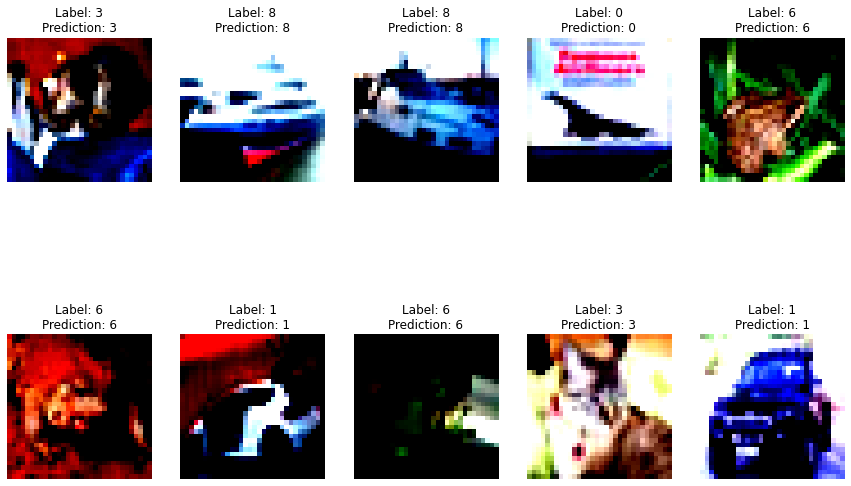

In [ ]:
fig, axs = plt.subplots(2 ,5, figsize=(15,10))
w=0
for i in range(2):
  for j in range(5):
    
    image = torchvision.utils.make_grid(correct_pred_list[w][0])
    image = image.numpy().transpose((1, 2, 0))
    label = correct_pred_list[w][1]
    prediction = correct_pred_list[w][2]
    axs[i,j].imshow(image)
    axs[i,j].set_title(f'Label: {label}\n' \
                 f'Prediction: {prediction}')
    axs[i,j].axis('off')
    w+=1
#fig.savefig()

# Pot incorrect cases:

Let's show 10 cases where the model failed to predict the correct digit:

In [ ]:
wrong_pred_list = [] ## list where the necessary data for the incorrect predictions will be
for i in range(len(input_images)):
  if pred[i]!=image_labels[i]:
    wrong_pred_list.append((input_images[i], image_labels[i], pred[i]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

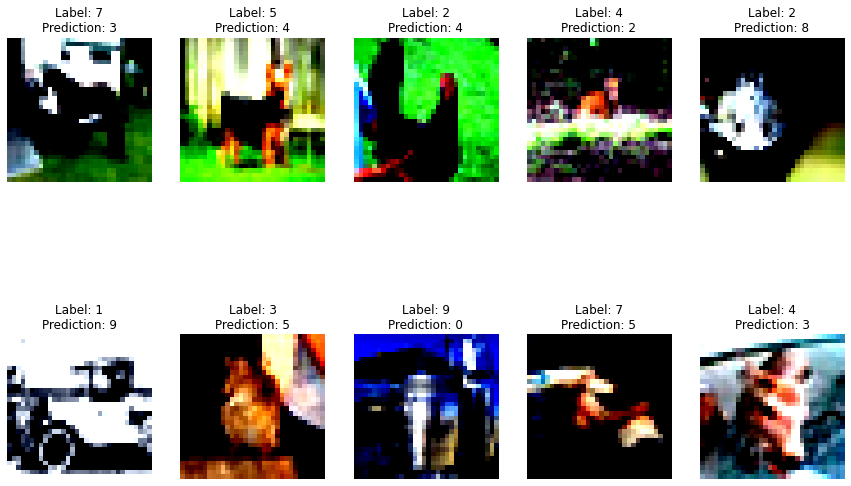

In [ ]:
fig, axs = plt.subplots(2 ,5, figsize=(15,10))
k=0
for i in range(2):
  for j in range(5):
    
    image = torchvision.utils.make_grid(wrong_pred_list[k][0])
    image = image.numpy().transpose((1, 2, 0))
    label = wrong_pred_list[k][1]
    prediction = wrong_pred_list[k][2]
    axs[i,j].imshow(image)
    axs[i,j].set_title(f'Label: {label}\n' \
                 f'Prediction: {prediction}')
    axs[i,j].axis('off')
    k+=1
#fig.savefig()

# Confusion Matrix:

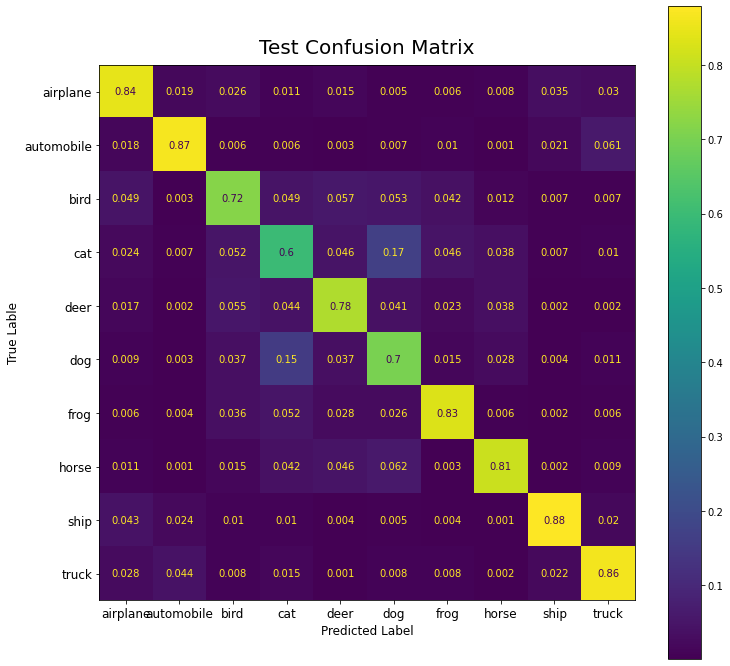

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(12,12))
conf_matrix = confusion_matrix(image_labels, pred, normalize='true')
plot_matrix = ConfusionMatrixDisplay(conf_matrix, test.classes)
plot_matrix.plot(ax=axs)
axs.tick_params(labelsize=12)
axs.set_xlabel('Predicted Label', fontsize=12)
axs.set_ylabel('True Lable',fontsize=12)
axs.set_title('Test Confusion Matrix', fontsize=20, y=1.01)
#fig.savefig()

# Loss plot:

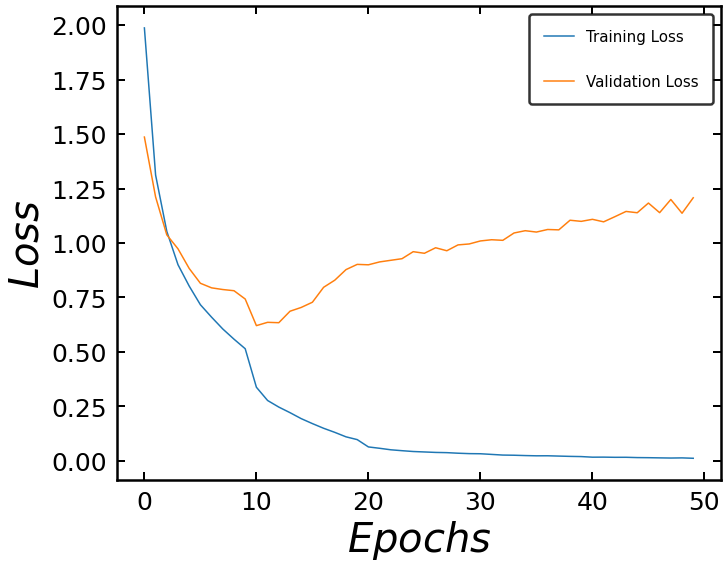

In [ ]:
fig, axs = plt.subplots(1,1, figsize = (10,8))

axs.plot(range(num_epochs), full_train_loss, label = 'Training Loss')
axs.plot(range(num_epochs), full_val_loss, label = 'Validation Loss')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(2.5)

#axs.set_title('VGG13, lr=0.1, momentum=0.7, weigth_decay = 0.0005', fontsize=25, y=1.02)
axs.set_xlabel('$Epochs$', fontsize=40)
axs.xaxis.set_ticks_position('both')
axs.set_ylabel('$Loss$', fontsize=40)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=8, width=2, direction="in", pad=10, labelsize=20)

axs.tick_params(labelsize=25)
legend = axs.legend(borderpad=1, labelspacing=2, fontsize=15, loc='best')
legend.get_frame().set_linewidth(2.5)
legend.get_frame().set_edgecolor('black')

plt.tight_layout()
#fig.savefig()

# Accuracy plot

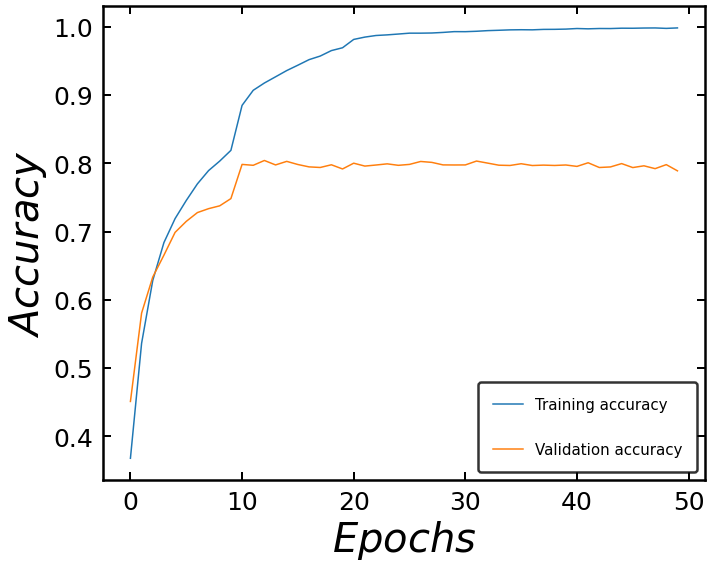

In [ ]:
fig, axs = plt.subplots(1,1, figsize = (10,8))

axs.plot(range(num_epochs), full_train_acc, label = 'Training accuracy')
axs.plot(range(num_epochs), full_val_acc, label = 'Validation accuracy')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(2.5)

#axs.set_title('VGG13, lr=0.1, momentum=0., weigth_decay = 0.0005', fontsize=25, y=1.02)
axs.set_xlabel('$Epochs$', fontsize=40)
axs.xaxis.set_ticks_position('both')
axs.set_ylabel('$Accuracy$', fontsize=40)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=8, width=2, direction="in", pad=10, labelsize=20)

axs.tick_params(labelsize=25)
legend = axs.legend(borderpad=1, labelspacing=2, fontsize=15, loc='best')
legend.get_frame().set_linewidth(2.5)
legend.get_frame().set_edgecolor('black')

plt.tight_layout()
#fig.savefig()